Stroke Dataset Analysis and Preprocessing
Comprehensive data preprocessing pipeline with PCA and SHAP analysis

In [1]:
#%pip install imbalanced-learn
#%pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import shap
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/dsi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
print("All required libraries imported successfully!")

All required libraries imported successfully!


# 1. Data Loading and Initial Exploration

In [5]:
# Load the dataset
df = pd.read_csv('../data/healthcare-dataset-stroke-data.csv')

In [6]:
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())

Dataset Shape: (5110, 12)

Column Names:
['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


In [7]:
print("\nFirst 5 rows:")
df.head()


First 5 rows:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
# Basic info about the dataset
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [9]:
print("\nBasic Statistics:")
df.describe()


Basic Statistics:


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


# 2. Data Quality Assessment

In [10]:
# Check for missing values
print("Missing Values:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percent.values
})
print(missing_df[missing_df['Missing_Count'] > 0])

Missing Values:
  Column  Missing_Count  Missing_Percentage
9    bmi            201            3.933464


In [11]:
# Check for "N/A" strings in BMI column
print(f"\nBMI 'N/A' values: {(df['bmi'] == 'N/A').sum()}")


BMI 'N/A' values: 0


In [12]:
# Check unique values for categorical variables
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
print("\nUnique values in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")


Unique values in categorical columns:
gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [13]:
# Target variable distribution
print("\nTarget Variable Distribution:")
print(df['stroke'].value_counts())
print(f"Class imbalance ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")
print(f"Positive class percentage: {(df['stroke'].sum() / len(df)) * 100:.2f}%")


Target Variable Distribution:
stroke
0    4861
1     249
Name: count, dtype: int64
Class imbalance ratio: 19.52:1
Positive class percentage: 4.87%


# 3. Exploratory Data Analysis

In [ ]:
# Create subplots for better visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

In [17]:
# Age distribution by stroke
sns.boxplot(data=df, x='stroke', y='age', ax=axes[0,0])
axes[0,0].set_title('Age Distribution by Stroke Status')

Text(0.5, 1.0, 'Age Distribution by Stroke Status')

In [18]:
# Gender distribution by stroke
stroke_gender = pd.crosstab(df['gender'], df['stroke'], normalize='index')
stroke_gender.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Stroke Rate by Gender')
axes[0,1].legend(['No Stroke', 'Stroke'])

In [19]:
# Work type distribution by stroke
stroke_work = pd.crosstab(df['work_type'], df['stroke'], normalize='index')
stroke_work.plot(kind='bar', ax=axes[1,0], rot=45)
axes[1,0].set_title('Stroke Rate by Work Type')
axes[1,0].legend(['No Stroke', 'Stroke'])

In [20]:
# Smoking status distribution by stroke
stroke_smoking = pd.crosstab(df['smoking_status'], df['stroke'], normalize='index')
stroke_smoking.plot(kind='bar', ax=axes[1,1], rot=45)
axes[1,1].set_title('Stroke Rate by Smoking Status')
axes[1,1].legend(['No Stroke', 'Stroke'])

In [22]:
plt.tight_layout()
plt.show()

<Figure size 800x550 with 0 Axes>

In [23]:
# Correlation matrix for numerical variables
numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'stroke']
df_numerical = df[numerical_cols].copy()

In [24]:
# Convert BMI to numerical, handling 'N/A' values
df_numerical['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')

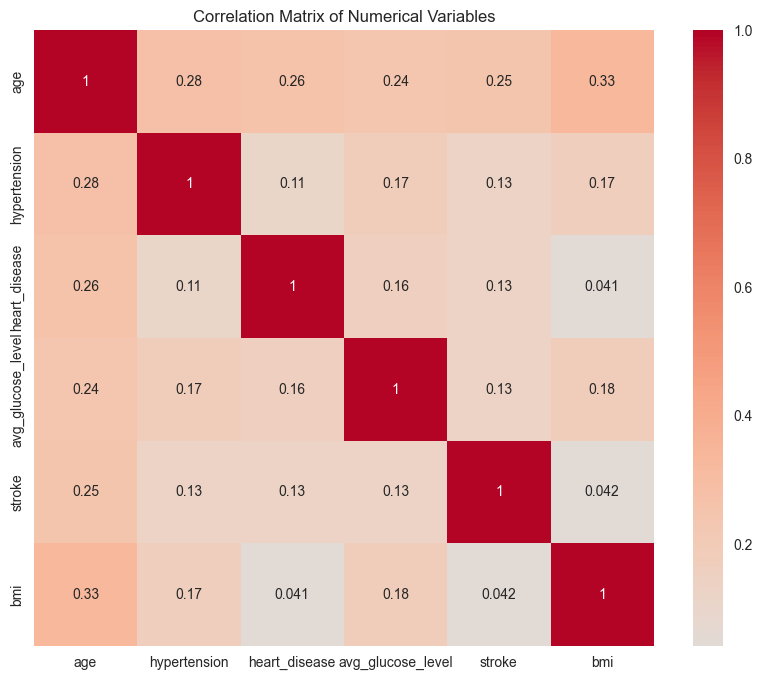

In [25]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_numerical.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# 4. Data Cleaning and Preprocessing

In [26]:
# Create a copy for preprocessing
df_clean = df.copy()

In [27]:
# Handle BMI 'N/A' values - convert to NaN for proper imputation
df_clean['bmi'] = pd.to_numeric(df_clean['bmi'], errors='coerce')

In [28]:
print(f"BMI missing values after conversion: {df_clean['bmi'].isnull().sum()}")

BMI missing values after conversion: 201


In [29]:
# Drop ID column as it's not useful for prediction
df_clean = df_clean.drop('id', axis=1)

In [30]:
# Separate features and target
X = df_clean.drop('stroke', axis=1)
y = df_clean['stroke']

In [31]:
# Identify categorical and numerical columns
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

In [32]:
print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

Categorical features: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numerical features: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']


# 5. Missing Value Imputation

In [33]:
# For numerical features, use KNN imputation
numerical_imputer = KNNImputer(n_neighbors=5)
X_numerical = X[numerical_features].copy()
X_numerical_imputed = numerical_imputer.fit_transform(X_numerical)
X_numerical_imputed = pd.DataFrame(X_numerical_imputed, columns=numerical_features, index=X.index)

In [34]:
# For categorical features, use mode imputation
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_categorical = X[categorical_features].copy()
X_categorical_imputed = categorical_imputer.fit_transform(X_categorical)
X_categorical_imputed = pd.DataFrame(X_categorical_imputed, columns=categorical_features, index=X.index)

In [35]:
print("Missing values after imputation:")
print("Numerical:", X_numerical_imputed.isnull().sum().sum())
print("Categorical:", X_categorical_imputed.isnull().sum().sum())

Missing values after imputation:
Numerical: 0
Categorical: 0


# 6. Feature Engineering

In [36]:
# Create age groups
def categorize_age(age):
    if age < 18:
        return 'Child'
    elif age < 35:
        return 'Young Adult'
    elif age < 55:
        return 'Middle-aged'
    elif age < 75:
        return 'Senior'
    else:
        return 'Elderly'

In [37]:
X_numerical_imputed['age_group'] = X_numerical_imputed['age'].apply(categorize_age)

In [38]:
# Create BMI categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

In [39]:
X_numerical_imputed['bmi_category'] = X_numerical_imputed['bmi'].apply(categorize_bmi)

In [40]:
# Create glucose level categories
def categorize_glucose(glucose):
    if glucose < 100:
        return 'Normal'
    elif glucose < 126:
        return 'Prediabetic'
    else:
        return 'Diabetic'

In [41]:
X_numerical_imputed['glucose_category'] = X_numerical_imputed['avg_glucose_level'].apply(categorize_glucose)

In [42]:
# Create health risk score
X_numerical_imputed['health_risk_score'] = (
    X_numerical_imputed['hypertension'] + 
    X_numerical_imputed['heart_disease'] + 
    (X_numerical_imputed['avg_glucose_level'] > 125).astype(int) +
    (X_numerical_imputed['bmi'] > 30).astype(int)
)

In [43]:
print("New engineered features created:")
print("- age_group")
print("- bmi_category") 
print("- glucose_category")
print("- health_risk_score")

New engineered features created:
- age_group
- bmi_category
- glucose_category
- health_risk_score


# 7. Encoding Categorical Variables

In [44]:
# Combine all categorical features (original + engineered)
new_categorical_features = ['age_group', 'bmi_category', 'glucose_category']
all_categorical_features = categorical_features + new_categorical_features

In [45]:
# Prepare categorical data
X_categorical_all = pd.concat([
    X_categorical_imputed,
    X_numerical_imputed[new_categorical_features]
], axis=1)

In [46]:
# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_categorical_encoded = encoder.fit_transform(X_categorical_all)

In [47]:
# Get feature names after encoding
encoded_feature_names = encoder.get_feature_names_out(all_categorical_features)
X_categorical_encoded = pd.DataFrame(X_categorical_encoded, columns=encoded_feature_names, index=X.index)

In [48]:
print(f"Categorical features after encoding: {X_categorical_encoded.shape[1]} features")

Categorical features after encoding: 28 features


# 8. Feature Scaling

In [49]:
# Combine numerical features (excluding the ones used for creating categories)
numerical_features_final = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'health_risk_score']
X_numerical_final = X_numerical_imputed[numerical_features_final]

In [50]:
# Scale numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical_final)
X_numerical_scaled = pd.DataFrame(X_numerical_scaled, columns=numerical_features_final, index=X.index)

In [51]:
# Combine all processed features
X_processed = pd.concat([X_numerical_scaled, X_categorical_encoded], axis=1)

In [52]:
print(f"Final processed dataset shape: {X_processed.shape}")
print(f"Total features: {X_processed.shape[1]}")

Final processed dataset shape: (5110, 34)
Total features: 34


# 9. Handle Class Imbalance

In [53]:
# Split data first
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

In [54]:
print("Original class distribution in training set:")
print(y_train.value_counts())

Original class distribution in training set:
stroke
0    3889
1     199
Name: count, dtype: int64


In [55]:
# Apply different resampling techniques
resampling_techniques = {}

In [56]:
# 1. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
resampling_techniques['SMOTE'] = (X_train_smote, y_train_smote)

In [57]:
# 2. ADASYN
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
resampling_techniques['ADASYN'] = (X_train_adasyn, y_train_adasyn)

In [58]:
# 3. SMOTETomek (combination)
smotetomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train, y_train)
resampling_techniques['SMOTETomek'] = (X_train_smotetomek, y_train_smotetomek)

In [59]:
# 4. Random Under Sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
resampling_techniques['UnderSampling'] = (X_train_rus, y_train_rus)

In [60]:
print("\nClass distribution after resampling:")
for technique, (X_resampled, y_resampled) in resampling_techniques.items():
    print(f"{technique}: {y_resampled.value_counts().to_dict()}")


Class distribution after resampling:
SMOTE: {0: 3889, 1: 3889}
ADASYN: {1: 3913, 0: 3889}
SMOTETomek: {0: 3887, 1: 3887}
UnderSampling: {0: 199, 1: 199}


# 10. Principal Component Analysis (PCA)

In [61]:
# Apply PCA to reduce dimensionality
pca = PCA()
X_train_pca = pca.fit_transform(X_train_smote)  # Using SMOTE-resampled data

In [62]:
# Calculate cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

In [63]:
# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to explain 95% variance: {n_components_95}")

Number of components to explain 95% variance: 15


In [ ]:
# Plot PCA analysis 
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

In [65]:
# Scree plot
axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
axes[0].axvline(x=n_components_95, color='r', linestyle='--')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Variance Explained')
axes[0].set_title('PCA: Cumulative Variance Explained')
axes[0].legend()
axes[0].grid(True)

In [66]:
# Individual component variance
axes[1].bar(range(1, min(21, len(pca.explained_variance_ratio_) + 1)), 
           pca.explained_variance_ratio_[:20])
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Variance Explained')
axes[1].set_title('Individual Component Variance (First 20)')
axes[1].grid(True)

In [68]:
plt.tight_layout()
plt.show()

<Figure size 800x550 with 0 Axes>

In [70]:
# Apply PCA with optimal number of components
pca_optimal = PCA(n_components=n_components_95)
X_train_pca_optimal = pca_optimal.fit_transform(X_train_smote)
X_test_pca_optimal = pca_optimal.transform(X_test)

In [71]:
print(f"Original feature space: {X_train_smote.shape[1]} dimensions")
print(f"Reduced feature space: {X_train_pca_optimal.shape[1]} dimensions")
print(f"Variance retained: {pca_optimal.explained_variance_ratio_.sum():.4f}")

Original feature space: 34 dimensions
Reduced feature space: 15 dimensions
Variance retained: 0.9592


# 11. Feature Importance Analysis with Multiple Models

In [72]:
# Train multiple models for feature importance analysis
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

In [73]:
feature_importance_results = {}


Training Random Forest...


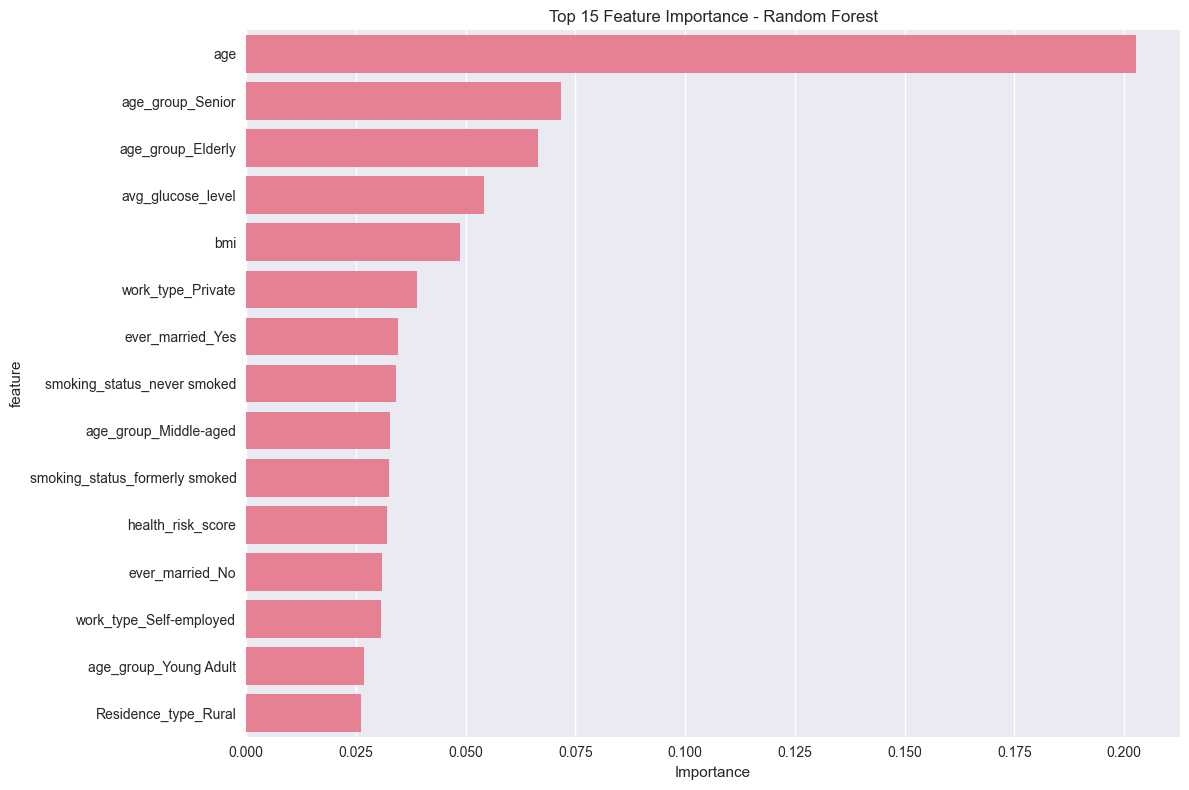

Top 10 features for Random Forest:
                           feature  importance
0                              age    0.202569
25                age_group_Senior    0.071645
23               age_group_Elderly    0.066577
3                avg_glucose_level    0.054229
4                              bmi    0.048818
13               work_type_Private    0.038887
10                ever_married_Yes    0.034562
20     smoking_status_never smoked    0.034204
24           age_group_Middle-aged    0.032728
19  smoking_status_formerly smoked    0.032646

Training Logistic Regression...


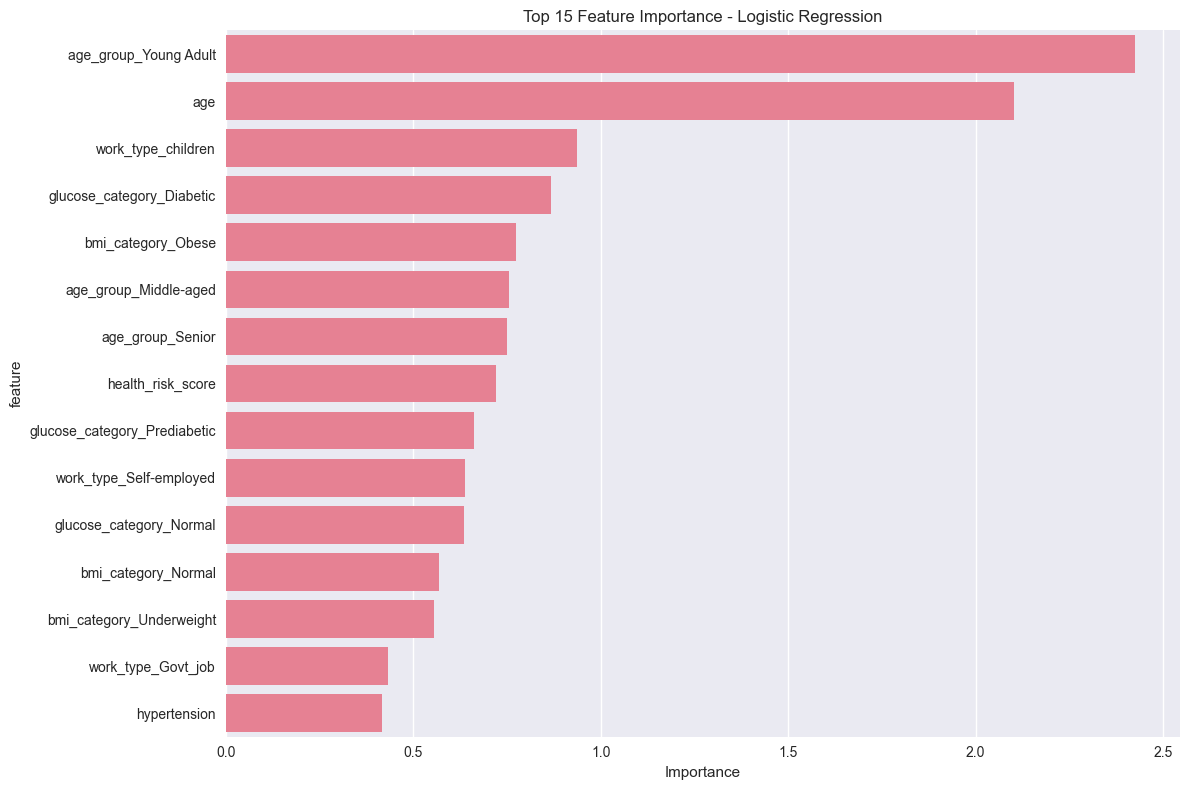

Top 10 features for Logistic Regression:
                         feature  importance
26         age_group_Young Adult    2.423560
0                            age    2.100850
15            work_type_children    0.937012
31     glucose_category_Diabetic    0.867152
28            bmi_category_Obese    0.774751
24         age_group_Middle-aged    0.756095
25              age_group_Senior    0.748703
5              health_risk_score    0.721712
33  glucose_category_Prediabetic    0.662587
14       work_type_Self-employed    0.638157


In [74]:
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_smote, y_train_smote)
    
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    else:
        continue
    
    # Create feature importance dataframe
    feature_names = X_processed.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    feature_importance_results[name] = importance_df
    
    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title(f'Top 15 Feature Importance - {name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print(f"Top 10 features for {name}:")
    print(importance_df.head(10))

# 12. SHAP Analysis

In [75]:
print("Performing SHAP analysis...")

Performing SHAP analysis...


In [76]:
# Use a smaller sample for SHAP analysis to speed up computation
sample_size = min(1000, len(X_train_smote))
sample_indices = np.random.choice(len(X_train_smote), sample_size, replace=False)
X_shap_sample = X_train_smote.iloc[sample_indices]
y_shap_sample = y_train_smote.iloc[sample_indices]

In [77]:
# Train Random Forest for SHAP analysis
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [78]:
# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_shap_sample)

In [79]:
# For binary classification, use positive class SHAP values
if isinstance(shap_values, list):
    shap_values_positive = shap_values[1]  # Positive class (stroke = 1)
else:
    shap_values_positive = shap_values

<Figure size 1200x800 with 0 Axes>

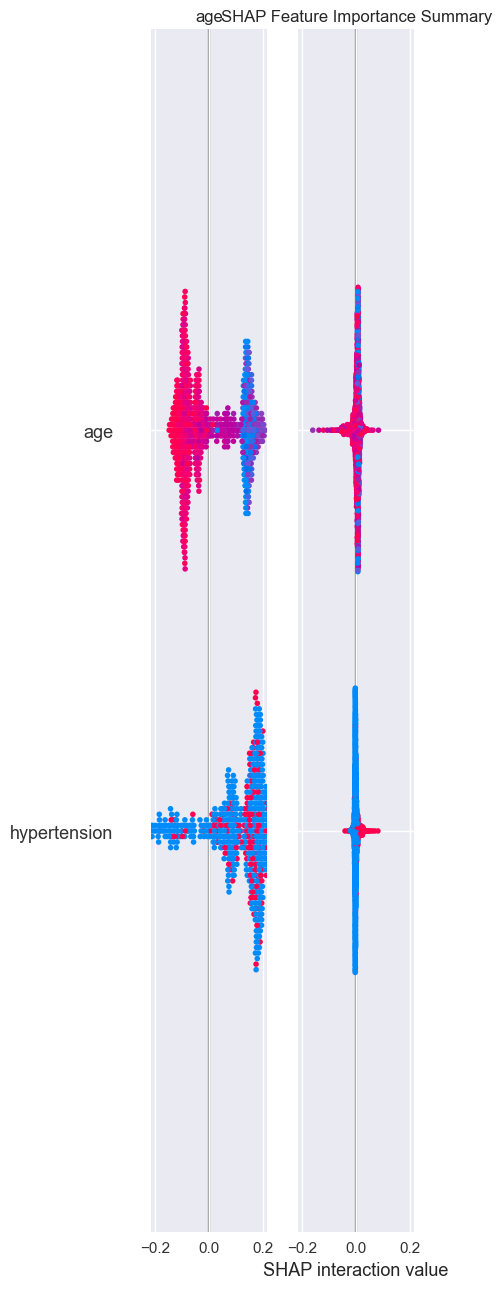

In [80]:
# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_shap_sample, max_display=15, show=False)
plt.title('SHAP Feature Importance Summary')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

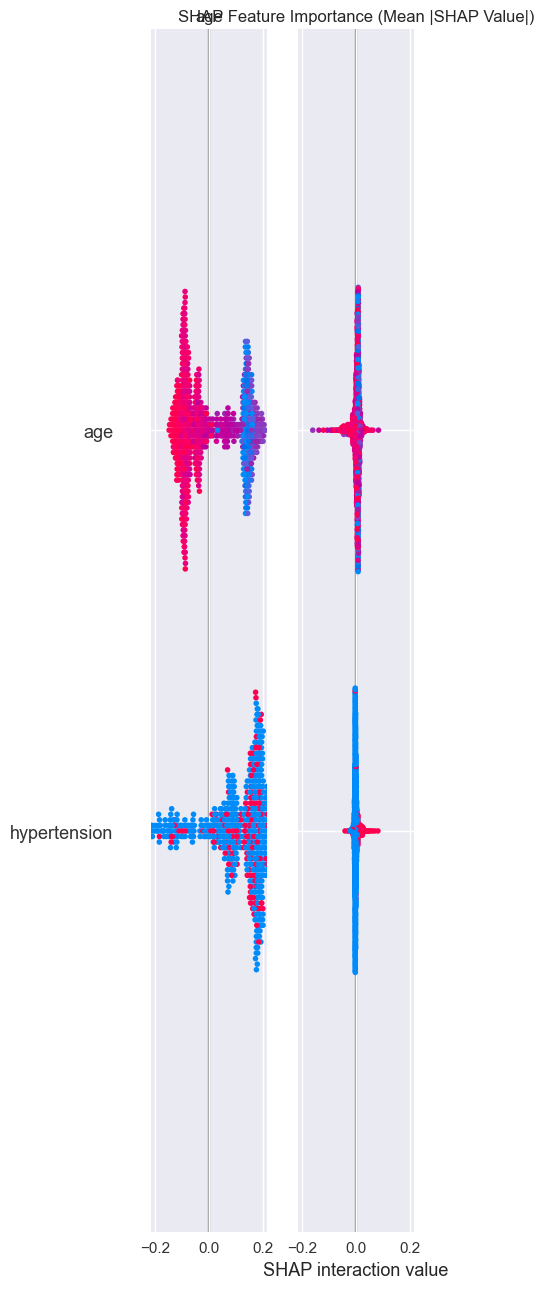

In [81]:
# SHAP Bar Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_shap_sample, plot_type="bar", max_display=15, show=False)
plt.title('SHAP Feature Importance (Mean |SHAP Value|)')
plt.tight_layout()
plt.show()

In [83]:
# Calculate mean absolute SHAP values for ranking
# If mean_abs_shap is 2D, select the positive class (second column)
mean_abs_shap = np.abs(shap_values_positive).mean(axis=0)
if mean_abs_shap.ndim == 2 and mean_abs_shap.shape[1] == 2:
    mean_abs_shap = mean_abs_shap[:, 1]  # Use positive class

feature_names = X_processed.columns
shap_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

In [84]:
print("Top 15 features by SHAP importance:")
print(shap_importance.head(15))

Top 15 features by SHAP importance:
                           feature  mean_abs_shap
0                              age       0.098990
23               age_group_Elderly       0.057086
25                age_group_Senior       0.049198
13               work_type_Private       0.028187
20     smoking_status_never smoked       0.022103
19  smoking_status_formerly smoked       0.021835
26           age_group_Young Adult       0.021392
14         work_type_Self-employed       0.019074
10                ever_married_Yes       0.017997
9                  ever_married_No       0.017725
5                health_risk_score       0.017294
16            Residence_type_Rural       0.017003
17            Residence_type_Urban       0.016663
18          smoking_status_Unknown       0.015125
24           age_group_Middle-aged       0.014658


# 13. Summary and Recommendations

In [85]:
print("\n" + "="*50)
print("DATA PREPROCESSING SUMMARY")
print("="*50)


DATA PREPROCESSING SUMMARY


In [87]:
print(f"""
Original Dataset:
- Shape: {df.shape}
- Missing BMI values: 201 (3.93%)
- Class imbalance: 19.52:1 (4.87% positive class)

Data Cleaning:
- Imputed BMI using KNN imputation
- Created engineered features: age_group, bmi_category, glucose_category, health_risk_score
- One-hot encoded categorical variables
- Standardized numerical features

Final Processed Dataset:
- Shape: {X_processed.shape}
- Features after encoding: {X_processed.shape[1]}

Class Imbalance Handling:
- Applied SMOTE, ADASYN, SMOTETomek, and UnderSampling
- SMOTE recommended for initial modeling

PCA Analysis:
- {n_components_95} components explain 95% of variance
- Dimensionality reduction from {X_processed.shape[1]} to {n_components_95} features

Key Findings:
""")


Original Dataset:
- Shape: (5110, 12)
- Missing BMI values: 201 (3.93%)
- Class imbalance: 19.52:1 (4.87% positive class)

Data Cleaning:
- Imputed BMI using KNN imputation
- Created engineered features: age_group, bmi_category, glucose_category, health_risk_score
- One-hot encoded categorical variables
- Standardized numerical features

Final Processed Dataset:
- Shape: (5110, 34)
- Features after encoding: 34

Class Imbalance Handling:
- Applied SMOTE, ADASYN, SMOTETomek, and UnderSampling
- SMOTE recommended for initial modeling

PCA Analysis:
- 15 components explain 95% of variance
- Dimensionality reduction from 34 to 15 features

Key Findings:



In [88]:
print("Top 5 Most Important Features (Random Forest):")
if 'Random Forest' in feature_importance_results:
    for i, row in feature_importance_results['Random Forest'].head(5).iterrows():
        print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

Top 5 Most Important Features (Random Forest):
  1. age: 0.2026
  26. age_group_Senior: 0.0716
  24. age_group_Elderly: 0.0666
  4. avg_glucose_level: 0.0542
  5. bmi: 0.0488


In [89]:
print("\nTop 5 Most Important Features (SHAP):")
for i, (_, row) in enumerate(shap_importance.head(5).iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['mean_abs_shap']:.4f}")


Top 5 Most Important Features (SHAP):
  1. age: 0.0990
  2. age_group_Elderly: 0.0571
  3. age_group_Senior: 0.0492
  4. work_type_Private: 0.0282
  5. smoking_status_never smoked: 0.0221


In [ ]:
print(f"""
Recommendations for Model Building:
1. Use SMOTE-resampled data for training
2. Consider both original features and PCA-transformed features
3. Focus on top features identified by SHAP analysis
4. Use stratified cross-validation due to class imbalance
5. Consider ensemble methods given feature diversity
6. Monitor for overfitting due to class imbalance

Next Steps:
1. Experiment with different algorithms using MLflow
2. Tune hyperparameters for optimal performance  
3. Evaluate models using appropriate metrics (ROC-AUC, Precision-Recall)
4. Implement proper cross-validation strategy
""")

In [90]:
# Save processed data for model building
print("\nSaving processed datasets...")


Saving processed datasets...


In [91]:
# Save different versions for experimentation
datasets_to_save = {
    'original_processed': (X_processed, y),
    'smote_resampled': (X_train_smote, y_train_smote),
    'pca_transformed': (pd.DataFrame(X_train_pca_optimal), y_train_smote),
    'test_set': (X_test, y_test)
}

In [92]:
for name, (X_data, y_data) in datasets_to_save.items():
    X_data.to_csv(f'X_{name}.csv', index=False)
    pd.Series(y_data).to_csv(f'y_{name}.csv', index=False)

In [93]:
print("All datasets saved successfully!")
print("\nNotebook execution completed!")

All datasets saved successfully!

Notebook execution completed!
